In [1]:
# # tensorflow_federated_nightly also bring in tf_nightly, which
# # can causes a duplicate tensorboard install, leading to errors.
# !pip uninstall --yes tensorboard tb-nightly

# !pip install --quiet --upgrade tensorflow_federated_nightly
# !pip install --quiet --upgrade nest_asyncio
# !pip install --quiet tb-nightly  # or tensorboard, but not both

import nest_asyncio
nest_asyncio.apply()

In [2]:
%load_ext tensorboard

In [3]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

/home/yitzhang/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210103). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


b'Hello, World!'

In [4]:
import pandas as pd
import numpy as np

filename = 'BRAZPD_UnofM_all.csv'

df = pd.read_csv(filename, engine='python')

In [5]:
display(df)

,CODPAX,Hemoglobin,Potassium,Phosphate,Mean_PAS_1T,Mean_PAD_1T,Mean_PAS_2T,Mean_PAD_2T,Mean_PAS_3T,Mean_PAD_3T,...,Diastolic70,Systolic71,Diastolic71,Systolic72,Diastolic72,Systolic73,Diastolic73,Systolic74,Diastolic74,_merge
0,1349037,12.933333,4.433333,5.300000,110.500000,70.000000,125.000000,80.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,1349040,14.000000,3.766667,5.933333,129.500000,77.000000,120.333333,68.666667,136.000000,82.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,1349048,11.833333,4.366667,6.100000,158.000000,81.000000,154.666667,87.666667,147.000000,80.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,1349051,10.066667,4.733333,5.533333,140.000000,75.000000,147.333333,92.333333,169.333333,99.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,1349055,11.933333,4.033333,4.066667,103.500000,60.000000,154.666667,82.000000,129.333333,72.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5702,347457070,8.400000,5.500000,4.700000,126.666667,76.666667,126.666667,83.333333,120.000000,80.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5703,347457071,9.700000,4.300000,3.233333,130.000000,80.000000,113.333333,73.333333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5704,347457072,10.466667,4.433333,4.466667,136.666667,80.000000,143.333333,73.333333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5705,347457073,11.766667,4.533333,3.566667,126.666667,80.000000,136.666667,83.333333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


# Data Cleaning

In [6]:
import re

nMeasurements = 75
nColumns = 1735
nRecords = 5707
timeseries_names = ['Ureia', 'Creatinine', 'TGP', 'Potassium', 'Calcium', 'Phosphate', 'Glucose', 
              'Hemoglobin', 'Hematocrit','Volume_Total', 'Systolic', 'Diastolic', 'N_AH_']

different_format_ts_names = ['Mes_1_PAS', 'Mes_1_PAD', 'Mes_1_Uso_de_anti_hipert', 'Mes_1_inibidor',\
                             'Mes_1_beta', 'Mes_1_ant', 'Mes_1_diu', 'Mes_1_at_i', 'Mes_1_OUTROS']

# Put timeseries names into standard format
p = re.compile('[0-9]')
strip = re.compile('Mes_[0-9]_')
for timeseries in different_format_ts_names:
    for i in range(1,nMeasurements):
        try:
            old_label = p.sub(str(i), timeseries)
            new_label = strip.sub('',timeseries)
            df[new_label+str(i)] = pd.Series(df[old_label])
            df.drop([old_label],axis=1, inplace=True)
        except:
            print(f'Column {timeseries}{i} does not exist')
    timeseries_names.append(new_label)
    
# make sure we don't have duplicate columns
assert nColumns == df.shape[1]

rename_dict = dict()
rename_keys = {"Uso_de_anti_hipert": "Use antihypertensive drug",\
               "inibidor": "ACE-inhibitor",\
               "at_i": "ATI blocker",\
               "beta": "beta-blocker",\
               "ant": "calcium antagonist",\
               "diu": "diuretic"}
for item in rename_keys.items():
    key, value = item
    for i in range(74):
        new_key = key+str(i+1)
        new_value = value+str(i+1)
        rename_dict[new_key] = new_value
        
df = df.rename(columns=rename_dict)

display(df)

,CODPAX,Hemoglobin,Potassium,Phosphate,Mean_PAS_1T,Mean_PAD_1T,Mean_PAS_2T,Mean_PAD_2T,Mean_PAS_3T,Mean_PAD_3T,...,OUTROS65,OUTROS66,OUTROS67,OUTROS68,OUTROS69,OUTROS70,OUTROS71,OUTROS72,OUTROS73,OUTROS74
0,1349037,12.933333,4.433333,5.300000,110.500000,70.000000,125.000000,80.000000,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1349040,14.000000,3.766667,5.933333,129.500000,77.000000,120.333333,68.666667,136.000000,82.000000,...,0,0,0,0,0,0,0,0,0,0
2,1349048,11.833333,4.366667,6.100000,158.000000,81.000000,154.666667,87.666667,147.000000,80.000000,...,0,0,0,0,0,0,0,0,0,0
3,1349051,10.066667,4.733333,5.533333,140.000000,75.000000,147.333333,92.333333,169.333333,99.000000,...,0,0,0,0,0,0,0,0,0,0
4,1349055,11.933333,4.033333,4.066667,103.500000,60.000000,154.666667,82.000000,129.333333,72.666667,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5702,347457070,8.400000,5.500000,4.700000,126.666667,76.666667,126.666667,83.333333,120.000000,80.000000,...,0,0,0,0,0,0,0,0,0,0
5703,347457071,9.700000,4.300000,3.233333,130.000000,80.000000,113.333333,73.333333,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5704,347457072,10.466667,4.433333,4.466667,136.666667,80.000000,143.333333,73.333333,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5705,347457073,11.766667,4.533333,3.566667,126.666667,80.000000,136.666667,83.333333,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.loc[df['Primaryrenaldisease']==81,'Primary renal disease (Diabetes)'] = 1

df.loc[df['Primaryrenaldisease']==100,'Primary renal disease (Hypertension)'] = 1

df.loc[df['Primaryrenaldisease']==13,'Primary renal disease (CGN (including LES))'] = 1
df.loc[df['Primaryrenaldisease']==10,'Primary renal disease (CGN (including LES))'] = 1

df.loc[df['Primaryrenaldisease']==0,'Primary renal disease (Unknown)'] = 1

df.loc[df['Primaryrenaldisease']==20,'Primary renal disease (Others)'] = 1
df.loc[df['Primaryrenaldisease']==20,'Primary renal disease (Others)'] = 1
df.loc[df['Primaryrenaldisease']==30,'Primary renal disease (Others)'] = 1
df.loc[df['Primaryrenaldisease']==40,'Primary renal disease (Others)'] = 1
df.loc[df['Primaryrenaldisease']==42,'Primary renal disease (Others)'] = 1
df.loc[df['Primaryrenaldisease']==50,'Primary renal disease (Others)'] = 1
df.loc[df['Primaryrenaldisease']==70,'Primary renal disease (Others)'] = 1

df.fillna(0)

,CODPAX,Hemoglobin,Potassium,Phosphate,Mean_PAS_1T,Mean_PAD_1T,Mean_PAS_2T,Mean_PAD_2T,Mean_PAS_3T,Mean_PAD_3T,...,OUTROS70,OUTROS71,OUTROS72,OUTROS73,OUTROS74,Primary renal disease (Diabetes),Primary renal disease (Hypertension),Primary renal disease (CGN (including LES)),Primary renal disease (Unknown),Primary renal disease (Others)
0,1349037,12.933333,4.433333,5.300000,110.500000,70.000000,125.000000,80.000000,0.000000,0.000000,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
1,1349040,14.000000,3.766667,5.933333,129.500000,77.000000,120.333333,68.666667,136.000000,82.000000,...,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0
2,1349048,11.833333,4.366667,6.100000,158.000000,81.000000,154.666667,87.666667,147.000000,80.000000,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
3,1349051,10.066667,4.733333,5.533333,140.000000,75.000000,147.333333,92.333333,169.333333,99.000000,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
4,1349055,11.933333,4.033333,4.066667,103.500000,60.000000,154.666667,82.000000,129.333333,72.666667,...,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5702,347457070,8.400000,5.500000,4.700000,126.666667,76.666667,126.666667,83.333333,120.000000,80.000000,...,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0
5703,347457071,9.700000,4.300000,3.233333,130.000000,80.000000,113.333333,73.333333,0.000000,0.000000,...,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0
5704,347457072,10.466667,4.433333,4.466667,136.666667,80.000000,143.333333,73.333333,0.000000,0.000000,...,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0
5705,347457073,11.766667,4.533333,3.566667,126.666667,80.000000,136.666667,83.333333,0.000000,0.000000,...,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0


# Feature Selection and Combination

In [8]:
# Separate features to unique features and time series features
timeseries_cols = []
time_indices = str(np.arange(100))
# print(time_indices)
for col in list(df.columns):
    add = True
    for idx in time_indices:
        if idx in col:
            add = False
    if add == False:
        timeseries_cols.append(col)
        
# Adjust missclassified features
adjlist = ['ModalidadeCAPD0APD1Mix2', 'Dropoutsim1', 'Agedic65', 'Educationdic4y', 
           'Followup1y', 'Followup2y', 'Followup3y', "death_event_1y","Tech_event_1y",
          "death_event_2y","Tech_event_2y", "death_event_3y","Tech_event_3y"]
for i in range(len(adjlist)):
    timeseries_cols.remove(adjlist[i])
    
unique_cols = ['Hemoglobin', 'Potassium', 'Phosphate',\
                 'FRR', 'codigoclinica', 'ModalidadeCAPD0APD1Mix2',\
                'CenterSizenpatients', 'ModalidadeDPInicial', 'Age',\
                'BMI','IncidentinPD', 'PrevalentinPDNet', \
                'DialysisvintageprePDNet', 'totaldialysisvintage',\
                'Primary renal disease (Diabetes)','Primary renal disease (Hypertension)',\
                'Primary renal disease (CGN (including LES))', 'Primary renal disease (Unknown)',\
                'Primary renal disease (Others)', 'PreviousHD',\
                'Previoustx', 'DaviesScore', 'Peripheralarterydisease',\
                'DM', 'CAD', 'LVH', 'LES', 'HF', 'Cancer', 'Stroke',\
                'Hypertension', 'HIV', 'HCV', 'HBC', 'Gender',\
                'Familyincome', 'Distancefromcenter', 'predialysiscare',\
                'timeofpredialysiscare', 'Racedicwhite', 'Educationdic4y',\
                'Region', 'Centerexperiencepatientyear',\
                'Regionsdic', 'cidade']

print(unique_cols)
print(timeseries_cols)

['Hemoglobin', 'Potassium', 'Phosphate', 'FRR', 'codigoclinica', 'ModalidadeCAPD0APD1Mix2', 'CenterSizenpatients', 'ModalidadeDPInicial', 'Age', 'BMI', 'IncidentinPD', 'PrevalentinPDNet', 'DialysisvintageprePDNet', 'totaldialysisvintage', 'Primary renal disease (Diabetes)', 'Primary renal disease (Hypertension)', 'Primary renal disease (CGN (including LES))', 'Primary renal disease (Unknown)', 'Primary renal disease (Others)', 'PreviousHD', 'Previoustx', 'DaviesScore', 'Peripheralarterydisease', 'DM', 'CAD', 'LVH', 'LES', 'HF', 'Cancer', 'Stroke', 'Hypertension', 'HIV', 'HCV', 'HBC', 'Gender', 'Familyincome', 'Distancefromcenter', 'predialysiscare', 'timeofpredialysiscare', 'Racedicwhite', 'Educationdic4y', 'Region', 'Centerexperiencepatientyear', 'Regionsdic', 'cidade']
['Mean_PAS_1T', 'Mean_PAD_1T', 'Mean_PAS_2T', 'Mean_PAD_2T', 'Mean_PAS_3T', 'Mean_PAD_3T', 'Mean_PAS_4T', 'Mean_PAD_4T', 'Mean_PAS_5T', 'Mean_PAD_5T', 'Mean_PAS_6T', 'Mean_PAD_6T', 'Mean_PAS_7T', 'Mean_PAD_7T', 'Mean_P

In [9]:
# build baseline dataframe (without time-series data):
df_baseline = df[unique_cols].copy()
df_baseline = df_baseline.fillna(0)
# display(df_baseline)

targets = ['Dropoutsim1', 'Followup1y', 'Followup2y', 'Followup3y',\
           "death_event_1y","Tech_event_1y",\
           "death_event_2y","Tech_event_2y",\
           "death_event_3y","Tech_event_3y",\
           "Deathevent","TechniqueFailureevent","Causeofdeath","TechFailureDeathnotcens","Causeofdropout",\
           "Followup"]

# build targets dataframe:
Y = df[targets+['CODPAX']].copy()
# display(Y)

In [10]:
df_totalaverage = df[unique_cols].copy()

# rename column name to understandable English
df_totalaverage = df_totalaverage.rename(columns={"codigoclinica": "Clinic code",\
                                                  "ModalidadeCAPD0APD1Mix2": "CAPD0APD1Mix2 modality",\
                                                  "CenterSizenpatients": "Center size (patients)",\
                                                  "ModalidadeDPInicial": "Initial modality of PD",\
                                                  "IncidentinPD": "Incident in PD",\
                                                  "PrevalentinPDNet": "Prevalent in PD Net",\
                                                  "DialysisvintageprePDNet": "Dialysis vintage pre PD Net",\
                                                  "totaldialysisvintage": "Total dialysis vintage",\
                                                  "PreviousHD": "Previous HD",\
                                                  "Previoustx": "Previous tx",\
                                                  "DaviesScore": "Davies Score",\
                                                  "Peripheralarterydisease": "Peripheral artery disease",\
                                                  "Familyincome": "Family income",\
                                                  "Distancefromcenter": "Distance from center",\
                                                  "predialysiscare": "Predialysis care",\
                                                  "timeofpredialysiscare": "Time of predialysis care",\
                                                  "Racedicwhite": "Race is white",\
                                                  "Educationdic4y": "Education more than 4 years",\
                                                  "Centerexperiencepatientyear": "Center experience (patient-year)",\
                                                  "cidade": "City"})

Group_p1 = []
Ms10ou_p1 = []

storage_p1 = [Group_p1, Ms10ou_p1]

Mean_PAS_p1 = []
Mean_PAD_p1 = []

Mean_PAS_p2 = []
Mean_PAD_p2 = []

storage_p2 = [Mean_PAS_p1, Mean_PAD_p1, Mean_PAS_p2, Mean_PAD_p2]

Ureia = dict()
Creatinine = dict()
TGP = dict()
Potassium = dict()
Calcium = dict()
Phosphate = dict()
Glucose = dict()
Hemoglobin = dict()
Hematocrit = dict()
Volume_Total = dict()
N_AH_ = dict()
Systolic = dict()
Diastolic = dict()
PAS = dict()
PAD = dict()
Uso_de_anti_hipert = dict()
inibidor = dict()
at_i = dict()
beta = dict()
ant = dict()
diu = dict()

# label_dict = [Ureia, Creatinine, TGP, Potassium, Calcium, Phosphate, Glucose, 
#               Hemoglobin, Hematocrit, Volume_Total, N_AH_, Systolic, Diastolic, PAS, PAD, Uso_de_anti_hipert, inibidor]

# label_str = ['Ureia', 'Creatinine', 'TGP', 'Potassium', 'Calcium', 'Phosphate', 'Glucose', 
#               'Hemoglobin', 'Hematocrit','Volume_Total', 'N_AH_', 'Systolic', 'Diastolic','PAS','PAD',
#              'Uso_de_anti_hipert', 'inibidor']

# remove Volume_Total and N_AH_

label_dict = [Ureia, Creatinine, TGP, Potassium, Calcium, Phosphate, Glucose, 
              Hemoglobin, Hematocrit, Systolic, Diastolic, PAS, PAD, Uso_de_anti_hipert, 
              inibidor, at_i, beta, ant, diu]

# label_str = ['Ureia', 'Creatinine', 'TGP', 'Potassium', 'Calcium', 'Phosphate',\
#              'Glucose', 'Hemoglobin', 'Hematocrit', 'Systolic', 'Diastolic','PAS','PAD',\
#              'Uso_de_anti_hipert', 'inibidor', 'at_i', 'beta', 'ant', 'diu']

label_str = ['Ureia', 'Creatinine', 'TGP', 'Potassium', 'Calcium', 'Phosphate',\
             'Glucose', 'Hemoglobin', 'Hematocrit', 'Systolic', 'Diastolic','PAS','PAD',\
             'Use antihypertensive drug', 'ACE-inhibitor', 'ATI blocker', 'beta-blocker',\
             'calcium antagonist', 'diuretic']

for item in label_dict:
    for i in range(13):
        key = 'p'+str(i+1)
        item[key] = []
    
label_idx = 0    
for item in label_dict:
    count = 0
    section = 1
    labelname = label_str[label_idx]
    for col in timeseries_cols:
        if labelname in col:
            if 'Mean_' not in col:            
                if count < 6:
                    count = count + 1
                else:
                    section = section + 1
                    count = 1
                key = 'p'+str(section)
                try:
                    item[key].append(col)
                except:
                    pass
                    
                    
    label_idx = label_idx + 1

indices_p1 = ['Group', 'Ms10ou']

indices_p2 = ['Mean_PAS', 'Mean_PAD']



# Select certain features as 1 section
for col in timeseries_cols:
    i = 0
    for idx in indices_p1:
        if idx in col:
            storage_p1[i].append(col)
        i = i + 1
# print(storage_p1)

# Separate certain features to 2 sections (each section contains 4 features)
i = 0 # i is the index of feature name
for idx in indices_p2:
    p = 0
    count = 0
    for col in timeseries_cols:
        if idx in col:
            if count < 4:
                storage_p2[i+2*p].append(col)
                count = count + 1
            else:
                count = 0
                p = p + 1
                storage_p2[i+2*p].append(col)
                count = count + 1
    i = i + 1

for i in range(len(indices_p1)):
    df_totalaverage.loc[:,indices_p1[i]] = df[storage_p1[i]].mean(axis=1)

for i in range(len(indices_p2)):
    for p in range(2):
        name = indices_p2[i][0:4] + ' ' + indices_p2[i][5:] + ' p' + str(p+1)
        df_totalaverage.loc[:,name] = df[storage_p2[i+2*p]].mean(axis=1)       

label_idx = 0
for item in label_dict:
    for p in range(13):
        name = label_str[label_idx] + ' p' + str(p+1)
        df_totalaverage.loc[:,name] = df[item['p'+str(p+1)]].mean(axis=1)
    label_idx = label_idx + 1
        
    
df_totalaverage = df_totalaverage.fillna(0)
display(df_totalaverage)


,Hemoglobin,Potassium,Phosphate,FRR,Clinic code,CAPD0APD1Mix2 modality,Center size (patients),Initial modality of PD,Age,BMI,...,diuretic p4,diuretic p5,diuretic p6,diuretic p7,diuretic p8,diuretic p9,diuretic p10,diuretic p11,diuretic p12,diuretic p13
0,12.933333,4.433333,5.300000,0,1,0,128,0.0,71.2,20.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.000000,3.766667,5.933333,0,1,0,128,0.0,23.3,28.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11.833333,4.366667,6.100000,1,1,1,128,1.0,49.2,31.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.066667,4.733333,5.533333,1,1,0,128,0.0,48.3,27.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.933333,4.033333,4.066667,0,1,2,128,0.0,93.7,23.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5702,8.400000,5.500000,4.700000,1,347,1,66,1.0,31.8,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5703,9.700000,4.300000,3.233333,1,347,1,66,1.0,57.0,21.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5704,10.466667,4.433333,4.466667,1,347,1,66,1.0,84.0,23.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5705,11.766667,4.533333,3.566667,1,347,1,66,1.0,54.2,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
baseline = df[unique_cols].copy()

numofpatient = baseline.shape[0]

# labelnames = ['Ureia', 'Creatinine', 'TGP', 'Potassium', 'Calcium', 'Phosphate', 'Glucose', 
#               'Hemoglobin', 'Hematocrit','Volume_Total', 'N_AH_', 'Systolic', 'Diastolic',
#              'PAS', 'PAD', 'Uso_de_anti_hipert', 'inibidor']

# remove Volume_Total and N_AH_
labelnames = ['Ureia', 'Creatinine', 'TGP', 'Potassium', 'Calcium', 'Phosphate', 'Glucose', 
              'Hemoglobin', 'Hematocrit', 'Systolic', 'Diastolic',
             'PAS', 'PAD', 'Use antihypertensive drug', 'ACE-inhibitor', 'ATI blocker', 'beta-blocker',
              'calcium antagonist', 'diuretic']

dfs = [df[unique_cols], df[unique_cols], df[unique_cols]]
maxmonths = [6, 18, 30]


for year in range(3):
    dfs[year] = dfs[year].rename(columns={"codigoclinica": "Clinic code",\
                                                  "ModalidadeCAPD0APD1Mix2": "CAPD0APD1Mix2 modality",\
                                                  "CenterSizenpatients": "Center size (patients)",\
                                                  "ModalidadeDPInicial": "Initial modality of PD",\
                                                  "IncidentinPD": "Incident in PD",\
                                                  "PrevalentinPDNet": "Prevalent in PD Net",\
                                                  "DialysisvintageprePDNet": "Dialysis vintage pre PD Net",\
                                                  "totaldialysisvintage": "Total dialysis vintage",\
                                                  "Primaryrenaldisease": "Primary renal disease",\
                                                  "PreviousHD": "Previous HD",\
                                                  "Previoustx": "Previous tx",\
                                                  "DaviesScore": "Davies Score",\
                                                  "Peripheralarterydisease": "Peripheral artery disease",\
                                                  "Familyincome": "Family income",\
                                                  "Distancefromcenter": "Distance from center",\
                                                  "predialysiscare": "Predialysis care",\
                                                  "timeofpredialysiscare": "Time of predialysis care",\
                                                  "Racedicwhite": "Race is white",\
                                                  "Educationdic4y": "Education more than 4 years",\
                                                  "Centerexperiencepatientyear": "Center experience (patient-year)",\
                                                  "cidade": "City"})
    
    
    for labelname in labelnames:
        for patient_idx in range(numofpatient):
            # compute the max index of month including nonzero data
            maxmonth = maxmonths[year]
            maxname = labelname + str(maxmonth)
            temp = df.at[patient_idx, maxname]
            while temp == 0 and maxmonth >= maxmonths[year]-5:
                maxmonth = maxmonth - 1
                maxname = labelname + str(maxmonth)
                if maxmonth >= maxmonths[year]-5:
                    temp = df.at[patient_idx, maxname]

            # compute the average of 3 months
            mean_months = 0
            if maxmonth >= maxmonths[year]-3:
                for i in range(maxmonth-2, maxmonth+1):
                    name = labelname + str(i)
                    mean_months = mean_months + df.at[patient_idx, name]
                mean_months = mean_months/3
            elif maxmonth == maxmonths[year]-4:
                for i in range(maxmonth-1, maxmonth+1):
                    name = labelname + str(i)
                    mean_months = mean_months + df.at[patient_idx, name]
                mean_months = mean_months/2
            elif maxmonth == maxmonths[year]-5:
                name = labelname + str(maxmonth)
                mean_months = df.at[patient_idx, name]
            else:
                mean_months = 0
            yearname = str(year+1)+'Y'
            name = labelname + ' mean months ' + yearname
            dfs[year].loc[patient_idx, name] = mean_months


extra_1y = ['Mean_PAS_1T', 'Mean_PAD_1T']
extra_2y = ['Mean_PAS_3T', 'Mean_PAD_3T']
extra_3y = ['Mean_PAS_5T', 'Mean_PAD_5T']
extras = [extra_1y, extra_2y, extra_3y]

for year in range(3):
    for index in extras[year]:
            new_name = index[0:4] + ' ' + index[5:8] + ' ' + index[9:]
            dfs[year].loc[:,new_name] = df[index]    
    dfs[year] = dfs[year].fillna(0)
    dfs[year].drop(columns = ['Total dialysis vintage'] , inplace=True)
        
display(dfs[1])

,Hemoglobin,Potassium,Phosphate,FRR,Clinic code,CAPD0APD1Mix2 modality,Center size (patients),Initial modality of PD,Age,BMI,...,PAS mean months 2Y,PAD mean months 2Y,Use antihypertensive drug mean months 2Y,ACE-inhibitor mean months 2Y,ATI blocker mean months 2Y,beta-blocker mean months 2Y,calcium antagonist mean months 2Y,diuretic mean months 2Y,Mean PAS 3T,Mean PAD 3T
0,12.933333,4.433333,5.300000,0,1,0,128,0.0,71.2,20.7,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,14.000000,3.766667,5.933333,0,1,0,128,0.0,23.3,28.3,...,135.666667,73.0,0.0,0.0,0.0,0.0,0.000000,0.0,136.000000,82.000000
2,11.833333,4.366667,6.100000,1,1,1,128,1.0,49.2,31.5,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,147.000000,80.000000
3,10.066667,4.733333,5.533333,1,1,0,128,0.0,48.3,27.1,...,174.666667,84.0,1.0,1.0,0.0,0.0,0.333333,0.0,169.333333,99.000000
4,11.933333,4.033333,4.066667,0,1,2,128,0.0,93.7,23.1,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,129.333333,72.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5702,8.400000,5.500000,4.700000,1,347,1,66,1.0,31.8,22.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,120.000000,80.000000
5703,9.700000,4.300000,3.233333,1,347,1,66,1.0,57.0,21.5,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
5704,10.466667,4.433333,4.466667,1,347,1,66,1.0,84.0,23.5,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
5705,11.766667,4.533333,3.566667,1,347,1,66,1.0,54.2,35.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


# Federated learning binary classification

* The follow-up event in the 1st, 2nd and 3rd year

In [12]:
year = 1 #input year you want to investigate

NUM_EPOCHS = 3
BATCH_SIZE = 64
SHUFFLE_BUFFER = 50

client_learning_rate = 0.01
server_learning_rate = 0.01

In [13]:
import matplotlib.pyplot as plt
import keras

if year == 1:
    X_full = dfs[0].copy()
    temp = Y["Followup"]

    n_full = X_full.shape[0]
    n_features = X_full.shape[1]

    y_full_array = np.zeros((n_full, ))
    for i in range(n_full):
        if temp[i] >= 12:
            y_full_array[i] = 1

    y_full = pd.DataFrame({'label': y_full_array})
    
elif year == 2:
    X_full = dfs[1].copy()
    indexNames = df[df["Followup1y"] < 12].index

    temp = Y["Followup"]

    n_full = X_full.shape[0]
    n_features = X_full.shape[1]

    y_full_array = np.zeros((n_full, ))
    for i in range(n_full):
        if temp[i] >= 24:
            y_full_array[i] = 1

    y_full = pd.DataFrame({'label': y_full_array})

    X_full.drop(indexNames , inplace=True)
    y_full.drop(indexNames , inplace=True)
    
elif year == 3:
    X_full = dfs[2].copy()
    indexNames = df[df["Followup2y"] < 24].index

    temp = Y["Followup"]

    n_full = X_full.shape[0]
    n_features = X_full.shape[1]

    y_full_array = np.zeros((n_full, ))
    for i in range(n_full):
        if temp[i] >= 36:
            y_full_array[i] = 1

    y_full = pd.DataFrame({'label': y_full_array})

    X_full.drop(indexNames , inplace=True)
    y_full.drop(indexNames , inplace=True)

else:
    print('Invalid year number! Please enter again.')

    
print(f"Full Data: \n X's shape: {X_full.shape} \n y's shape: {y_full.shape}")    
    
plt.figure()
client_ids = X_full['Clinic code']
client_ids.plot.hist()

unique_client_ids = set(client_ids)
unique_client_ids = list(unique_client_ids)
num_unique_client_ids = len(unique_client_ids)

print('unique client IDs:', unique_client_ids)
print('number of unique client IDs:', num_unique_client_ids)

Full Data: 
 X's shape: (5707, 65) 
 y's shape: (5707, 1)
unique client IDs: [1, 2, 3, 5, 6, 10, 12, 18, 23, 26, 30, 31, 33, 35, 43, 51, 54, 56, 57, 63, 67, 68, 69, 74, 77, 81, 82, 88, 92, 94, 95, 96, 102, 103, 106, 107, 109, 111, 112, 113, 115, 117, 119, 124, 125, 128, 132, 133, 134, 135, 140, 141, 144, 145, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 167, 171, 172, 174, 176, 177, 179, 180, 184, 186, 187, 191, 201, 208, 210, 214, 216, 217, 218, 221, 223, 226, 227, 229, 235, 237, 241, 248, 251, 258, 261, 262, 263, 267, 269, 270, 279, 280, 281, 283, 287, 290, 314, 320, 322, 331, 333, 334, 335, 336, 342, 343, 345, 346, 347]
number of unique client IDs: 121


In [14]:
from collections import Counter

def make_federated_data(X_full, y_full, selected_client_ids):
    X_res = pd.DataFrame()
    y_res = pd.DataFrame()
#     y_res = []
#     y_res = np.array(y_res)
    for selected_id in selected_client_ids:
        X_selected = X_full.loc[X_full['Clinic code'] == selected_id]
        X_res = pd.concat([X_res, X_selected], ignore_index=True)
        y_selected = y_full.loc[X_selected.index]
        y_res = pd.concat([y_res, y_selected], ignore_index=True)
        
    X_res.to_numpy
    X_res = tf.convert_to_tensor(X_res, dtype=tf.float32)
    y_res.to_numpy

    y_res = tf.convert_to_tensor(y_res, dtype=tf.int32)
    print('Number of samples: %d' % X_res.shape[0])
#     print(X_res.shape)
#     print(y_res.shape)

    res = tf.data.Dataset.from_tensor_slices((X_res, y_res))

    res = res.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    
    return res

def select_largest_clients(client_ids, k=10):
    sorted_list = [item for items, c in Counter(client_ids).most_common() 
                                      for item in [items]] 
    result = sorted_list[:k]
    return result

In [118]:
def create_keras_model():
    model = keras.Sequential([
                keras.layers.InputLayer(input_shape=(65,)),
                keras.layers.Dense(units=32, activation='relu',dtype='float64'),
                keras.layers.Dense(units=1, activation='sigmoid',dtype='float64')
            ])
    return model

def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
    
#     input_spec = collections.OrderedDict(
#         x=tf.TensorSpec(shape=[None, 66], dtype=tf.float32),
#         y=tf.TensorSpec(shape=[None, 1], dtype=tf.int32))
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=input_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

## Split by clinic ID

In [29]:
# import random

# # select clients randomly
# test_client_library = list()
# for client_id in unique_client_ids:
#     if client_id not in selected_client_ids:
#         test_client_library.append(client_id)

# test_client_ids = random.choices(unique_client_ids, k=24)
test_client_ids = [174, 2, 261, 281, 270, 82, 134, 94, 343, 54, 172, 208, 201, 57, 263, 333, 150, 241, 346, 94, 96, 201, 112, 152]

print('Selected clinic codes for testing: ', test_client_ids)

federated_test_data = make_federated_data(X_full, y_full, test_client_ids)

Selected clinic codes for testing:  [174, 2, 261, 281, 270, 82, 134, 94, 343, 54, 172, 208, 201, 57, 263, 333, 150, 241, 346, 94, 96, 201, 112, 152]
Number of samples: 1247


In [117]:
## Test making federated data
import random

# # select clients randomly
# selected_client_ids = random.choices(unique_client_ids, k=10)

# select clients according to frequency
client_ids_without_test = []
for index in client_ids:
    if index not in test_client_ids:
        client_ids_without_test.append(index)

# selected_client_ids = select_largest_clients(client_ids_without_test, k=12)
selected_client_ids = random.choices(client_ids_without_test, k=97)

print('Selected clinic codes for training: ', selected_client_ids)

federated_train_data = make_federated_data(X_full, y_full, selected_client_ids)

input_spec = federated_train_data.element_spec

# print(input_spec)

# for itr in federated_train_data:
#     print(itr)


Selected clinic codes for training:  [10, 157, 88, 159, 132, 135, 167, 12, 124, 147, 125, 117, 216, 125, 113, 159, 157, 147, 153, 334, 336, 119, 68, 43, 5, 223, 63, 10, 109, 167, 3, 77, 68, 167, 95, 51, 216, 3, 347, 167, 23, 176, 5, 216, 218, 63, 43, 218, 1, 124, 26, 151, 248, 115, 334, 132, 223, 111, 210, 235, 35, 154, 235, 117, 88, 279, 128, 117, 237, 262, 117, 18, 132, 210, 153, 103, 63, 30, 320, 77, 111, 133, 30, 5, 237, 106, 63, 320, 106, 167, 35, 124, 33, 30, 30, 154, 235]
Number of samples: 7539


In [119]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam())

# str(iterative_process.initialize.type_signature)

In [120]:
state = iterative_process.initialize()

In [130]:
NUM_ROUNDS = 50
for round_num in range(NUM_ROUNDS):
  state, metrics = iterative_process.next(state, [federated_train_data])
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  0, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.65990186), ('recall', 0.74240696), ('precision', 0.6936207), ('loss', 0.68086034)])), ('stat', OrderedDict([('num_examples', 22617)]))])
round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.65848696), ('recall', 0.7382964), ('precision', 0.6935288), ('loss', 0.68208724)])), ('stat', OrderedDict([('num_examples', 22617)]))])
round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.66127247), ('recall', 0.7459085), ('precision', 0.69388187), ('loss', 0.6845831)])), ('stat', OrderedDict([('num_examples', 22617)]))])
round  3, metrics=OrderedDict([('broadcast', 

round 26, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.6661803), ('recall', 0.74705034), ('precision', 0.6989531), ('loss', 0.6574186)])), ('stat', OrderedDict([('num_examples', 22617)]))])
round 27, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.66542864), ('recall', 0.74362487), ('precision', 0.69938433), ('loss', 0.66846824)])), ('stat', OrderedDict([('num_examples', 22617)]))])
round 28, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.671265), ('recall', 0.75451016), ('precision', 0.7018836), ('loss', 0.64981335)])), ('stat', OrderedDict([('num_examples', 22617)]))])
round 29, metrics=OrderedDict([('broadcast', (

In [131]:
# evaluation the model
evaluation = tff.learning.build_federated_evaluation(model_fn)
# str(evaluation.type_signature)

train_metrics = evaluation(state.model, [federated_train_data])

recall_train = train_metrics['recall']
precision_train = train_metrics['precision']
f1_train = 2 * recall_train * precision_train / (recall_train + precision_train)
print('Train:',
      'Year:', year,
      'Recall:', recall_train,
      'Precision:', precision_train,
      'F1 score:', f1_train)

test_metrics = evaluation(state.model, [federated_test_data])

recall_test = test_metrics['recall']
precision_test = test_metrics['precision']
f1_test = 2 * recall_test * precision_test / (recall_test + precision_test)
print('Test:',
      'Year:', year,
      'Recall:', recall_test,
      'Precision:', precision_test,
      'F1 score:', f1_test)

Train: Year: 1 Recall: 0.59579813 Precision: 0.7439407 F1 score: 0.6616789375218105
Test: Year: 1 Recall: 0.66803277 Precision: 0.6143216 F1 score: 0.6400523360748471


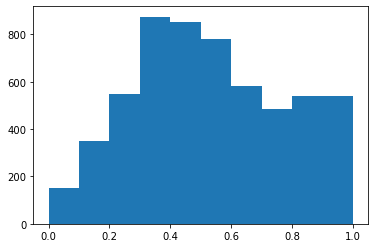

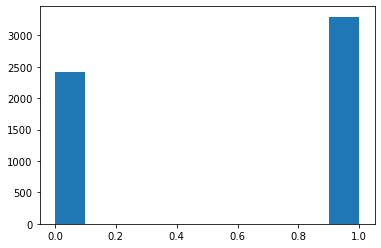

In [132]:
import matplotlib.pyplot as plt

trained_model = create_keras_model()

state.model.assign_weights_to(
    trained_model
)

prediction = trained_model.predict(X_full)

# print(prediction)
# print(y_full)


plt.hist(prediction)
plt.show()


plt.hist(y_full)
plt.show()

## Split by train-test ratio

In [161]:
# split train and test data
import random


def split_data_federated(X_full, y_full, train_ratio):
    X_train = pd.DataFrame()
    y_train = pd.DataFrame()
    X_test = pd.DataFrame()
    y_test = pd.DataFrame()
#     y_res = []
#     y_res = np.array(y_res)

    train_num = int(train_ratio * X_full.shape[0])
    test_num = X_full.shape[0] - train_num
    
    train_ids = random.sample(range(X_full.shape[0]), train_num)
    test_ids = random.sample(range(X_full.shape[0]), test_num)
    
    X_train = X_full.iloc[train_ids]
    y_train = y_full.iloc[train_ids]
    X_test = X_full.iloc[test_ids]
    y_test = y_full.iloc[test_ids]
    
#     for selected_id in selected_client_ids:
#         X_selected = X_full.loc[X_full['Clinic code'] == selected_id]
#         X_res = pd.concat([X_res, X_selected], ignore_index=True)
#         y_selected = y_full.loc[X_selected.index]
#         y_res = pd.concat([y_res, y_selected], ignore_index=True)
        
    X_train.to_numpy
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train.to_numpy
    y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
    X_test.to_numpy
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test.to_numpy
    y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)
    
#     print(X_res.shape)
#     print(y_res.shape)

    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    train_set = train_set.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    test_set = test_set.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    
    return train_set, test_set

In [174]:
train_ratio = 0.9
federated_train_data, federated_test_data = split_data_federated(X_full, y_full, train_ratio)
input_spec = federated_train_data.element_spec

In [175]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam())

In [178]:
state = iterative_process.initialize()

In [185]:
NUM_ROUNDS = 100
for round_num in range(NUM_ROUNDS):
  state, metrics = iterative_process.next(state, [federated_train_data])
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  0, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.63817495), ('recall', 0.7171956), ('precision', 0.6754637), ('loss', 0.6901554)])), ('stat', OrderedDict([('num_examples', 15408)]))])
round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.6400571), ('recall', 0.72180957), ('precision', 0.6760118), ('loss', 0.68861943)])), ('stat', OrderedDict([('num_examples', 15408)]))])
round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.635514), ('recall', 0.7086428), ('precision', 0.67535394), ('loss', 0.7068531)])), ('stat', OrderedDict([('num_examples', 15408)]))])
round  3, metrics=OrderedDict([('broadcast', ()),

round 26, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.6471314), ('recall', 0.7279991), ('precision', 0.68173677), ('loss', 0.669033)])), ('stat', OrderedDict([('num_examples', 15408)]))])
round 27, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.6491433), ('recall', 0.730925), ('precision', 0.6829653), ('loss', 0.668366)])), ('stat', OrderedDict([('num_examples', 15408)]))])
round 28, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.64479494), ('recall', 0.72428536), ('precision', 0.6804102), ('loss', 0.67727125)])), ('stat', OrderedDict([('num_examples', 15408)]))])
round 29, metrics=OrderedDict([('broadcast', ()), (

round 52, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.6476506), ('recall', 0.7212469), ('precision', 0.68464905), ('loss', 0.6763788)])), ('stat', OrderedDict([('num_examples', 15408)]))])
round 53, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.6474559), ('recall', 0.7223723), ('precision', 0.6840367), ('loss', 0.66326565)])), ('stat', OrderedDict([('num_examples', 15408)]))])
round 54, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.6482996), ('recall', 0.72180957), ('precision', 0.6851832), ('loss', 0.67818993)])), ('stat', OrderedDict([('num_examples', 15408)]))])
round 55, metrics=OrderedDict([('broadcast', ())

round 78, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.65524405), ('recall', 0.73002476), ('precision', 0.6901064), ('loss', 0.65940183)])), ('stat', OrderedDict([('num_examples', 15408)]))])
round 79, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.64823467), ('recall', 0.720009), ('precision', 0.6857449), ('loss', 0.6836829)])), ('stat', OrderedDict([('num_examples', 15408)]))])
round 80, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.6546599), ('recall', 0.7281116), ('precision', 0.69013333), ('loss', 0.65588236)])), ('stat', OrderedDict([('num_examples', 15408)]))])
round 81, metrics=OrderedDict([('broadcast', ()

In [186]:
# evaluation the model
evaluation = tff.learning.build_federated_evaluation(model_fn)
# str(evaluation.type_signature)

train_metrics = evaluation(state.model, [federated_train_data])

recall_train = train_metrics['recall']
precision_train = train_metrics['precision']
f1_train = 2 * recall_train * precision_train / (recall_train + precision_train)
print('Train:',
      'Year:', year,
      'Recall:', recall_train,
      'Precision:', precision_train,
      'F1 score:', f1_train)

test_metrics = evaluation(state.model, [federated_test_data])

recall_test = test_metrics['recall']
precision_test = test_metrics['precision']
f1_test = 2 * recall_test * precision_test / (recall_test + precision_test)
print('Test:',
      'Year:', year,
      'Recall:', recall_test,
      'Precision:', precision_test,
      'F1 score:', f1_test)

Train: Year: 1 Recall: 0.8629305 Precision: 0.6814183 F1 score: 0.761507568562586
Test: Year: 1 Recall: 0.8521739 Precision: 0.7033493 F1 score: 0.7706422420184373


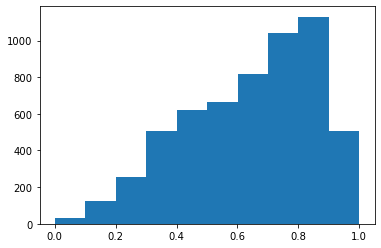

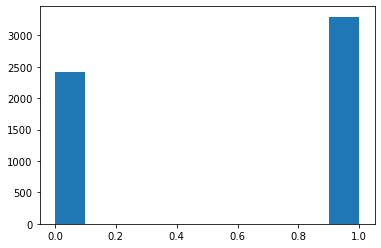

In [187]:
import matplotlib.pyplot as plt

trained_model = create_keras_model()

state.model.assign_weights_to(
    trained_model
)

prediction = trained_model.predict(X_full)

# print(prediction)
# print(y_full)


plt.hist(prediction)
plt.show()


plt.hist(y_full)
plt.show()